In [1]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

import logistic_regression_util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
import graphviz

from graphviz import Graph, Digraph
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from acquire import get_titanic_data
from prepare import prep_titanic, sex_encode
%matplotlib inline
warnings.filterwarnings('ignore')

## Mini Exercise

1. Load the titanic dataset that you've put together from previous lessons.
2. Split your data into training and test.
3. Fit a logistic regression model on your training data using sklearn's
   linear_model.LogisticRegression class. Use fare and pclass as the
   predictors.
4. Use the model's `.predict` method. What is the output?
5. Use the model's `.predict_proba` method. What is the output? Why do you
   think it is shaped like this?
6. Evaluate your model's predictions on the test data set. How accurate
   is the mode? How does changing the threshold affect this?

In [2]:
titanic = sns.load_dataset('titanic')[['fare', 'pclass', 'survived']]
train, test = train_test_split(titanic, random_state=123, train_size=.8)

X = train[['fare', 'pclass']]
y = train.survived

model = LogisticRegression(random_state=123).fit(X, y)

In [3]:
# unique values from the y variable
model.classes_

array([0, 1])

In [4]:
pd.DataFrame(model.predict_proba(X), columns=model.classes_)

,0,1
0,0.373222,0.626778
1,0.738207,0.261793
2,0.738643,0.261357
3,0.738220,0.261780
4,0.367825,0.632175
...,...,...
707,0.574824,0.425176
708,0.585981,0.414019
709,0.738061,0.261939
710,0.738622,0.261378


In [5]:
train['yhat'] = model.predict(X)
train['p_survived'] = model.predict_proba(X)[:, 1]

In [6]:
model.score(X, y)

0.672752808988764

In [7]:
accuracy_score(train.survived, train.yhat)

0.672752808988764

In [8]:
precision_score(train.survived, train.yhat, average=None)

array([0.68498168, 0.63253012])

In [9]:
recall_score(train.survived, train.yhat)

0.37906137184115524

In [10]:
t = .25
train['yhat'] = train.p_survived > t

accuracy_score(train.survived, train.yhat), precision_score(train.survived, train.yhat), recall_score(train.survived, train.yhat)

(0.3890449438202247, 0.3890449438202247, 1.0)

## More Complicated Example

- **validate data split** lets us compare models, tweak hyperparams, experiment with thresholds without leaking information from the test split
- train: fit models -- majority of our data
- validate: compare models, choose hyperparams, thresholds -- ~ 20% of our data
- test: to get an idea of *out of sample error* -- ~20% of our data

In [11]:
df = sns.load_dataset('titanic')[['fare', 'sex', 'pclass', 'survived']]
df.head()

,fare,sex,pclass,survived
0,7.2500,male,3,0
1,71.2833,female,1,1
2,7.9250,female,3,1
3,53.1000,female,1,1
4,8.0500,male,3,0


In [12]:
train, test = train_test_split(df, random_state=123, train_size=.86)
train, validate = train_test_split(train, random_state=123, train_size=.83)

print('    test: %d rows x %d columns' % test.shape)
print('   train: %d rows x %d columns' % train.shape)
print('validate: %d rows x %d columns' % validate.shape)

    test: 125 rows x 4 columns
   train: 635 rows x 4 columns
validate: 131 rows x 4 columns


In [13]:
model = smf.logit('survived ~ fare + sex + pclass', train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.465616
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  635
Model:                          Logit   Df Residuals:                      631
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Apr 2020   Pseudo R-squ.:                  0.3088
Time:                        12:28:07   Log-Likelihood:                -295.67
converged:                       True   LL-Null:                       -427.76
Covariance Type:            nonrobust   LLR p-value:                 5.559e-57
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3313      0.442      7.534      0.000       2.465       4.198
sex[T.male]    -2.6712      0.219    -12.223      0.000      -3.099      -2.243
fare            0.0005      0.003      0.187      0.852      -0.004       0.005
pclass         -0.9301      0.147     -6.348      0.000      -1.217      -0.643
===============================================================================
"""

In [14]:
probs = model.predict(train)
actual = train.survived

In [15]:
validate.survived.mean()

0.35877862595419846

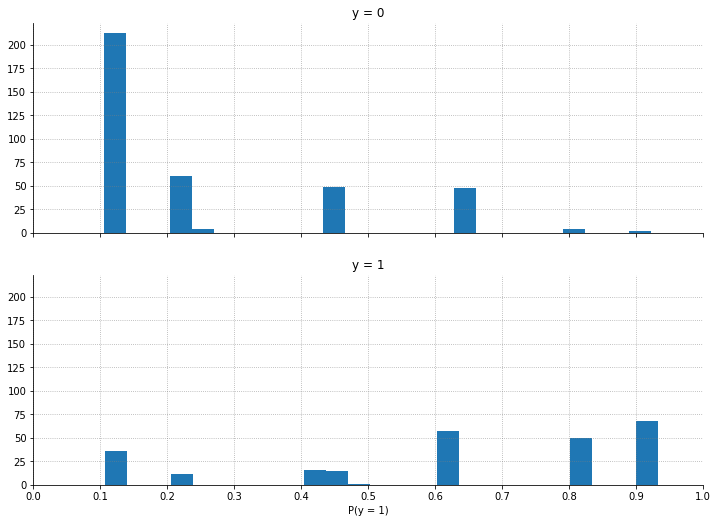

In [16]:
logistic_regression_util.plot_true_by_probs(actual, probs, subplots=True)

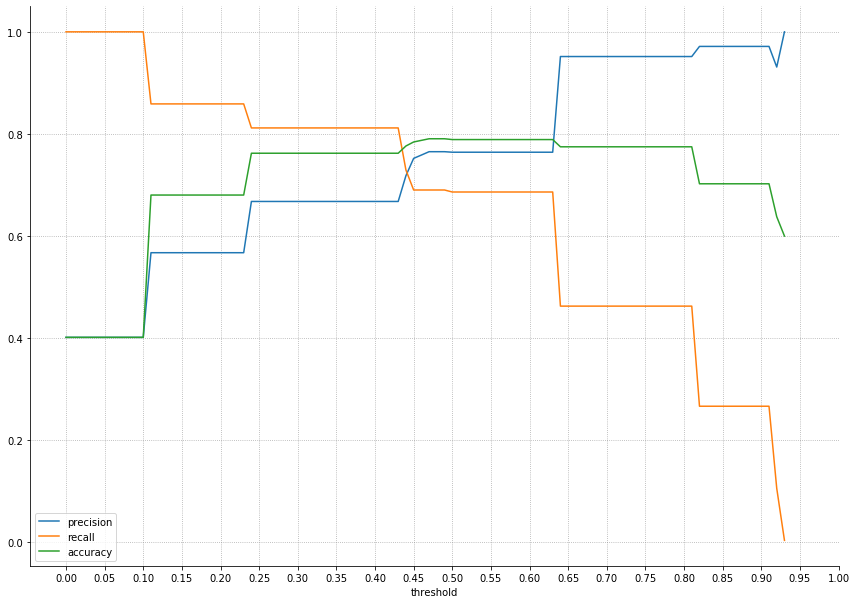

In [17]:
logistic_regression_util.plot_metrics_by_thresholds(actual, probs)

In [18]:
t = .55
probs = model.predict(test)
yhat = (probs > t).astype(int)
actual = test.survived

accuracy_score(actual, yhat)

0.816

# Main Exercise

In [19]:
df = get_titanic_data()
df.head()

- CodeUp_db successfully accessed ...
- titanic_db SQL query successful ...


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [20]:
scaler, ohe, train, test = prep_titanic(df)
le, train, test = sex_encode(train, test)
train.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,C,Q,S
683,683,0,3,1,0.184561,5,2,0.091543,S,Third,Southampton,0,0.0,0.0,1.0
421,421,0,3,1,0.279696,0,0,0.015094,Q,Third,Queenstown,1,0.0,1.0,0.0
336,336,0,1,1,0.388421,1,0,0.129995,S,First,Southampton,0,0.0,0.0,1.0
681,681,1,1,1,0.361239,0,0,0.149765,C,First,Cherbourg,1,1.0,0.0,0.0
610,610,0,3,0,0.524327,1,5,0.061045,S,Third,Southampton,0,0.0,0.0,1.0


In [21]:
train, validate = train_test_split(train, random_state=123, train_size=.75)

## Problem 1
- Create another model that includes age in addition to fare and pclass. 
- Does this model perform better than your previous one?

In [22]:
X_afp = train[['age','fare','pclass']]
y = train.survived

In [23]:
model = LogisticRegression(random_state=123).fit(X_afp, y)

In [24]:
train['yhat']= model.predict(X_afp)

In [25]:
age_fare_pclass_score = model.score(X_afp, y)
age_fare_pclass_score

0.6966067864271457

In [26]:
print(classification_report(y, train.yhat))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78       307
           1       0.66      0.44      0.53       194

    accuracy                           0.70       501
   macro avg       0.69      0.65      0.65       501
weighted avg       0.69      0.70      0.68       501



In [27]:
X_afps = train[['age','fare','pclass', 'sex']]

In [28]:
model = LogisticRegression(random_state=123).fit(X_afps, y)

In [29]:
train['yhat']= model.predict(X_afps)

In [30]:
X_afps_model_score = model.score(X_afps, y)

In [31]:
print('Accuracy with sex as a feature\n')
print(classification_report(y, train.yhat))

Accuracy with sex as a feature

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       307
           1       0.72      0.71      0.72       194

    accuracy                           0.78       501
   macro avg       0.77      0.77      0.77       501
weighted avg       0.78      0.78      0.78       501



In [32]:
X_afpsa = train[['age','fare','pclass', 'sex', 'alone']]

In [33]:
model = LogisticRegression(random_state=123).fit(X_afpsa, y)

In [34]:
train['yhat']= model.predict(X_afpsa)

In [35]:
model.score(X_afpsa, y)

0.780439121756487

In [36]:
print('Accuracy with alone as a feature\n')
print(classification_report(y, train.yhat))

Accuracy with alone as a feature

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       307
           1       0.72      0.71      0.71       194

    accuracy                           0.78       501
   macro avg       0.77      0.77      0.77       501
weighted avg       0.78      0.78      0.78       501



- age and sex only

In [37]:
X_as = train[['age', 'sex']]

In [38]:
model = LogisticRegression(random_state=123).fit(X_as, y)

In [39]:
train['yhat']= model.predict(X_as)

In [40]:
model.score(X_as, y)

0.7704590818363274

In [41]:
print('Accuracy with age and sex as features\n')
print(classification_report(y, train.yhat))

Accuracy with age and sex as features

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       307
           1       0.71      0.68      0.70       194

    accuracy                           0.77       501
   macro avg       0.76      0.75      0.76       501
weighted avg       0.77      0.77      0.77       501



In [42]:
X_afpa = train[['age','fare','pclass', 'alone']]

In [43]:
model = LogisticRegression(random_state=123).fit(X_afpa, y)

In [44]:
train['yhat']= model.predict(X_afpa)

In [45]:
model.score(X_afpa, y)

0.7145708582834331

In [46]:
print('Accuracy with age, fare, pclass, and alone as a feature\n')
print(classification_report(y, train.yhat))

Accuracy with age, fare, pclass, and alone as a feature

              precision    recall  f1-score   support

           0       0.72      0.86      0.79       307
           1       0.69      0.48      0.57       194

    accuracy                           0.71       501
   macro avg       0.71      0.67      0.68       501
weighted avg       0.71      0.71      0.70       501



In [47]:
features = ['age', 'fare', 'pclass', 'sex']
# X_afps_model_score

In [48]:
print(f'Using features {features}  and the Logistic Regression:')
print(f'- model X_afps has the highest score with {X_afps_model_score}')


Using features ['age', 'fare', 'pclass', 'sex']  and the Logistic Regression:
- model X_afps has the highest score with 0.782435129740519


## Test model with test data

In [49]:
X_afps_test = test[['age','fare','pclass', 'sex']]
y = test.survived

In [50]:
model = LogisticRegression(random_state=123).fit(X_afps_test, y)

In [51]:
test['yhat']= model.predict(X_afps_test)

In [52]:
X_afps_test_model_score = model.score(X_afps_test, y)
X_afps_test_model_score

0.7892376681614349

In [53]:
print(f'Accuracy with {features} as a feature\n')
print(classification_report(y, test.yhat))

Accuracy with ['age', 'fare', 'pclass', 'sex'] as a feature

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       137
           1       0.81      0.59      0.68        86

    accuracy                           0.79       223
   macro avg       0.80      0.75      0.76       223
weighted avg       0.79      0.79      0.78       223



## Decision Tree

In [54]:
df = get_titanic_data()
df.head()

- CodeUp_db successfully accessed ...
- titanic_db SQL query successful ...


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [55]:
df = df[["survived", "pclass", "sex", "age", "fare"]]
df.head()

,survived,pclass,sex,age,fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [56]:
def encode_gender(gender):
    if gender == "male":
        return 0
    else:
        return 1

In [57]:
df.sex = df.sex.apply(encode_gender)
df.head()

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       714 non-null    float64
 4   fare      891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB


In [59]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
fare          0
dtype: int64

In [60]:
df.age = df.age.fillna(df.age.median())

In [61]:
df.isna().sum()

survived    0
pclass      0
sex         0
age         0
fare        0
dtype: int64

In [62]:
X = df.drop('survived', axis=1)
y = df.survived

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [64]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

In [65]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [66]:
y_pred = clf.predict(X_train)
y_pred

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [67]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [68]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       379
           1       0.80      0.72      0.76       244

    accuracy                           0.82       623
   macro avg       0.82      0.80      0.81       623
weighted avg       0.82      0.82      0.82       623



## Model Performance using the test data

In [69]:
y_pred = clf.predict(X_test)

In [70]:
print(f"Accuracy of Decision Tree on Test data is: {clf.score(X_test, y_test)}")

Accuracy of Decision Tree on Test data is: 0.8208955223880597


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       170
           1       0.78      0.70      0.74        98

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268



## KNN Exercise
1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)
2. Evaluate your results using the model score, confusion matrix, and classification report.
3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [72]:
df = get_titanic_data()
scaler, ohe, train, test = prep_titanic(df)
le, train, test = sex_encode(train, test)
train.info()

- CodeUp_db successfully accessed ...
- titanic_db SQL query successful ...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 683 to 399
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  668 non-null    int64  
 1   survived      668 non-null    int64  
 2   pclass        668 non-null    int64  
 3   sex           668 non-null    int64  
 4   age           668 non-null    float64
 5   sibsp         668 non-null    int64  
 6   parch         668 non-null    int64  
 7   fare          668 non-null    float64
 8   embarked      668 non-null    object 
 9   class         668 non-null    object 
 10  embark_town   668 non-null    object 
 11  alone         668 non-null    int64  
 12  C             668 non-null    float64
 13  Q             668 non-null    float64
 14  S             668 non-null    float64
dtypes: float64(5), int64(7), object(3)
memory usage: 103.5+ KB


In [73]:
X_train = train[['pclass','age','fare','sibsp','parch']]
y_train = train[['survived']]
X_test = test[['pclass','age','fare','sibsp','parch']]
y_test = test[['survived']]

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 683 to 399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  668 non-null    int64  
 1   age     668 non-null    float64
 2   fare    668 non-null    float64
 3   sibsp   668 non-null    int64  
 4   parch   668 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 51.3 KB


In [75]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [76]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [77]:
y_pred = knn.predict(X_train)

In [78]:
y_pred_proba = knn.predict_proba(X_train)

In [79]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.79


In [80]:
print(confusion_matrix(y_train, y_pred))

[[345  67]
 [ 76 180]]


In [81]:
c_matrix = pd.DataFrame(confusion_matrix(y_train, y_pred))
c_matrix

,0,1
0,345,67
1,76,180


In [82]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       412
           1       0.73      0.70      0.72       256

    accuracy                           0.79       668
   macro avg       0.77      0.77      0.77       668
weighted avg       0.78      0.79      0.79       668



In [83]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.68


([<matplotlib.axis.XTick at 0x1037455d0>,
 <a list of 5 Text xticklabel objects>)

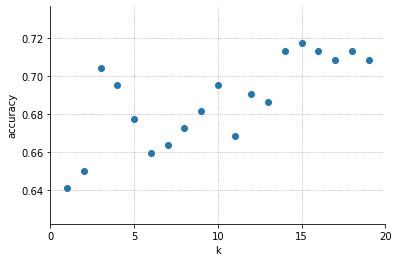

In [84]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

4. Run through steps 2-4 setting k to 10
5. Run through setps 2-4 setting k to 20
6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [85]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [86]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [87]:
y_pred = knn.predict(X_train)

In [88]:
y_pred_proba = knn.predict_proba(X_train)

In [89]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.75


In [90]:
print(confusion_matrix(y_train, y_pred))

[[373  39]
 [125 131]]


In [91]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       412
           1       0.77      0.51      0.62       256

    accuracy                           0.75       668
   macro avg       0.76      0.71      0.72       668
weighted avg       0.76      0.75      0.74       668



In [92]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.70


([<matplotlib.axis.XTick at 0x1a185ad9d0>,
 <a list of 5 Text xticklabel objects>)

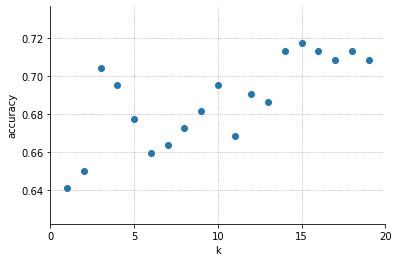

In [93]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### Run through setps 2-4 setting k to 20

In [94]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')

In [95]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [96]:
y_pred = knn.predict(X_train)

In [97]:
y_pred_proba = knn.predict_proba(X_train)

In [98]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.74


In [99]:
print(confusion_matrix(y_train, y_pred))

[[378  34]
 [143 113]]


In [100]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       412
           1       0.77      0.44      0.56       256

    accuracy                           0.74       668
   macro avg       0.75      0.68      0.69       668
weighted avg       0.74      0.74      0.71       668



In [101]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.71


([<matplotlib.axis.XTick at 0x1a185ee390>,
 <a list of 5 Text xticklabel objects>)

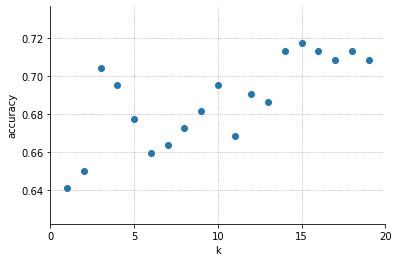

In [102]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

## Test
#### For both the iris and the titanic data,

1. Determine which model (with hyperparameters) performs the best (try reducing the number of features to the top 4 features in terms of information gained for each feature individually).
2. Create a new dataframe with top 4 features.
    - train[['age' , 'fare' , 'pclass' , 'sex']] and k = 10
3. Use the top performing algorithm with the metaparameters used in that model. Create the object, fit, transform on in-sample data, and evaluate the results with the training data. Compare your evaluation metrics with those from the original model (with all the features).
4. Run your final model on your out-of-sample dataframe (test_df). Evaluate the results.

In [103]:
# 1
X_train = train[['age' , 'fare' , 'pclass' , 'sex']]
y_train = train[['survived']]
X_test = test[['age' , 'fare' , 'pclass' , 'sex']]
y_test = test[['survived']]

In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 683 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     668 non-null    float64
 1   fare    668 non-null    float64
 2   pclass  668 non-null    int64  
 3   sex     668 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 46.1 KB


In [105]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn5.fit(X_train, y_train)
y_pred5 = knn5.predict(X_train)
y_pred5_proba = knn5.predict_proba(X_train)
print('k = 5')
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn5.score(X_train, y_train)))

k = 5
Accuracy of KNN classifier on training set: 0.88


In [106]:
print(confusion_matrix(y_train, y_pred))

[[378  34]
 [143 113]]


In [107]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       412
           1       0.77      0.44      0.56       256

    accuracy                           0.74       668
   macro avg       0.75      0.68      0.69       668
weighted avg       0.74      0.74      0.71       668



In [108]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn5.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.80


#### Run through steps 2-4 setting k to 10

In [109]:
knn10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn10.fit(X_train, y_train)
y_pred10 = knn10.predict(X_train)
y_pred10_proba = knn10.predict_proba(X_train)
print('k = 10')
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn10.score(X_train, y_train)))

k = 10
Accuracy of KNN classifier on training set: 0.82


In [110]:
print(confusion_matrix(y_train, y_pred))

[[378  34]
 [143 113]]


In [111]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       412
           1       0.77      0.44      0.56       256

    accuracy                           0.74       668
   macro avg       0.75      0.68      0.69       668
weighted avg       0.74      0.74      0.71       668



In [112]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn10.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.78


#### Run through steps 2-4 setting k to 20

In [113]:
knn20 = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn20.fit(X_train, y_train)
y_pred20 = knn20.predict(X_train)
y_pred20_proba = knn20.predict_proba(X_train)
print('k = 20')
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn20.score(X_train, y_train)))

k = 20
Accuracy of KNN classifier on training set: 0.80


In [114]:
print(confusion_matrix(y_train, y_pred))

[[378  34]
 [143 113]]


In [115]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       412
           1       0.77      0.44      0.56       256

    accuracy                           0.74       668
   macro avg       0.75      0.68      0.69       668
weighted avg       0.74      0.74      0.71       668



In [116]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn20.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.80
